In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('./fashion-mnist_train.csv')

In [3]:
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

data_dev = data[0:1000].T
y_dev = data_dev[0]
x_dev = data_dev[1:n] / 255

data_train = data[1000:m].T
y_train = data_train[0]
x_train = data_train[1:n] / 255


In [5]:
y_train

array([4, 6, 2, ..., 3, 6, 8], dtype=int64)

In [6]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
x_train[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [8]:
x_train[:, 0].shape

(784,)

In [9]:
def init_params():
    w1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    w2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return w1, b1, w2, b2

def relu(z):
    return np.maximum(0, z)

def softmax(z):
    a = np.exp(z) / sum(np.exp(z))
    return a

def fwd_prop(w1, b1, w2, b2, x):
    z1 = w1.dot(x) + b1
    a1 = relu(z1)
    z2 = w2.dot(a1) + b2
    a2 = softmax(z2)
    return z1, a1, z2, a2

def one_hot(y):
    oh_y = np.zeros((y.size, y.max() + 1))
    oh_y[np.arange(y.size), y] = 1
    oh_y = oh_y.T
    return oh_y

def d_relu(z):
    return (z > 0)

def back_prop(z1, a1, z2, a2, w1, w2, x, y):
    oh_y = one_hot(y)
    dz2 = a2 - oh_y
    dw2 = 1 / m * dz2.dot(a1.T)
    db2 = 1 / m * np.sum(dz2)
    dz1 = w2.T.dot(dz2) * d_relu(z1)
    dw1 = 1 / m * dz1.dot(x.T)
    db1 = 1 / m * np.sum(dz1)
    return dw1, db1, dw2, db2

def update_params(w1, b1, w2, b2, dw1, db1, dw2, db2, a, cache):
    # Update cache with squared gradients
    cache['dw1'] += dw1 ** 2
    cache['db1'] += db1 ** 2
    cache['dw2'] += dw2 ** 2
    cache['db2'] += db2 ** 2

    # Adagrad update
    w1 -= a * dw1 / (np.sqrt(cache['dw1']) + 1e-8)  # small constant for numerical stability
    b1 -= a * db1 / (np.sqrt(cache['db1']) + 1e-8)
    w2 -= a * dw2 / (np.sqrt(cache['dw2']) + 1e-8)
    b2 -= a * db2 / (np.sqrt(cache['db2']) + 1e-8)

    return w1, b1, w2, b2


In [10]:
def get_preds(a2):
    return np.argmax(a2, 0)

def get_acc(preds, y):
    print(preds, y)
    return np.sum(preds == y) / y.size

def compute_loss(a2, y):
    oh_y = one_hot(y)
    m = y.shape[0]
    log_likelihood = -np.log(a2[oh_y == 1])
    loss = np.sum(log_likelihood) / m
    return loss

def grad_desc(x, y, iters, a):
    w1, b1, w2, b2 = init_params()
    
    # Initialize Adam parameters
    m_w1, m_b1 = np.zeros_like(w1), np.zeros_like(b1)
    m_w2, m_b2 = np.zeros_like(w2), np.zeros_like(b2)
    v_w1, v_b1 = np.zeros_like(w1), np.zeros_like(b1)
    v_w2, v_b2 = np.zeros_like(w2), np.zeros_like(b2)

    beta1, beta2 = 0.9, 0.999
    epsilon = 1e-8  # To prevent division by zero
    
    for i in range(iters):
        z1, a1, z2, a2 = fwd_prop(w1, b1, w2, b2, x)
        dw1, db1, dw2, db2 = back_prop(z1, a1, z2, a2, w1, w2, x, y)
        
        # Update first and second moments
        m_w1 = beta1 * m_w1 + (1 - beta1) * dw1
        m_b1 = beta1 * m_b1 + (1 - beta1) * db1
        m_w2 = beta1 * m_w2 + (1 - beta1) * dw2
        m_b2 = beta1 * m_b2 + (1 - beta1) * db2

        v_w1 = beta2 * v_w1 + (1 - beta2) * (dw1 ** 2)
        v_b1 = beta2 * v_b1 + (1 - beta2) * (db1 ** 2)
        v_w2 = beta2 * v_w2 + (1 - beta2) * (dw2 ** 2)
        v_b2 = beta2 * v_b2 + (1 - beta2) * (db2 ** 2)

        # Bias correction
        m_w1_hat = m_w1 / (1 - beta1 ** (i + 1))
        m_b1_hat = m_b1 / (1 - beta1 ** (i + 1))
        m_w2_hat = m_w2 / (1 - beta1 ** (i + 1))
        m_b2_hat = m_b2 / (1 - beta1 ** (i + 1))

        v_w1_hat = v_w1 / (1 - beta2 ** (i + 1))
        v_b1_hat = v_b1 / (1 - beta2 ** (i + 1))
        v_w2_hat = v_w2 / (1 - beta2 ** (i + 1))
        v_b2_hat = v_b2 / (1 - beta2 ** (i + 1))

        # Parameter updates
        w1 -= a * m_w1_hat / (np.sqrt(v_w1_hat) + epsilon)
        b1 -= a * m_b1_hat / (np.sqrt(v_b1_hat) + epsilon)
        w2 -= a * m_w2_hat / (np.sqrt(v_w2_hat) + epsilon)
        b2 -= a * m_b2_hat / (np.sqrt(v_b2_hat) + epsilon)
        
        #w1, b1, w2, b2 = update_params(w1, b1, w2, b2, dw1, db1, dw2, db2, a)
        if (i % 50 == 0):
            print("Iteration: ", i, " Loss: ", compute_loss(a2, y));
            print("Accuracy: "+ str(get_acc(get_preds(a2), y)))
    return w1, b1, w2, b2

In [11]:
w1, b1, w2, b2 = grad_desc(x_train, y_train, 1000, 0.1)

Iteration:  0  Loss:  4.5931869042275775
[7 7 7 ... 7 3 7] [4 6 2 ... 3 6 8]
Accuracy: 0.0558135593220339
Iteration:  50  Loss:  2.0100653790677496
[4 4 4 ... 1 4 4] [4 6 2 ... 3 6 8]
Accuracy: 0.19089830508474576
Iteration:  100  Loss:  1.938560243985066
[4 4 4 ... 1 4 4] [4 6 2 ... 3 6 8]
Accuracy: 0.19320338983050847
Iteration:  150  Loss:  1.9285974914770156
[4 4 4 ... 1 4 4] [4 6 2 ... 3 6 8]
Accuracy: 0.19496610169491527
Iteration:  200  Loss:  1.9241028135338825
[4 4 4 ... 1 4 4] [4 6 2 ... 3 6 8]
Accuracy: 0.19822033898305086
Iteration:  250  Loss:  1.9217850310383524
[4 4 4 ... 1 4 4] [4 6 2 ... 3 6 8]
Accuracy: 0.19688135593220338
Iteration:  300  Loss:  1.9198504496211455
[4 4 4 ... 1 4 4] [4 6 2 ... 3 6 8]
Accuracy: 0.19696610169491524
Iteration:  350  Loss:  1.9225310347924536
[4 4 4 ... 1 4 4] [4 6 2 ... 3 6 8]
Accuracy: 0.20286440677966103
Iteration:  400  Loss:  1.9198090680325073
[4 4 4 ... 1 4 4] [4 6 2 ... 3 6 8]
Accuracy: 0.20371186440677966
Iteration:  450  Loss:  

In [12]:
w1, b1, w2, b2 = grad_desc(x_train, y_train, 1000, 0.0001)

Iteration:  0  Loss:  4.358197219437244
[6 6 6 ... 6 6 6] [4 6 2 ... 3 6 8]
Accuracy: 0.09771186440677966
Iteration:  50  Loss:  3.3273053665525185
[6 6 6 ... 6 6 6] [4 6 2 ... 3 6 8]
Accuracy: 0.10810169491525423
Iteration:  100  Loss:  2.7682950850345245
[6 6 6 ... 6 6 6] [4 6 2 ... 3 6 8]
Accuracy: 0.12584745762711863
Iteration:  150  Loss:  2.453834418073449
[6 8 6 ... 8 8 8] [4 6 2 ... 3 6 8]
Accuracy: 0.1578135593220339
Iteration:  200  Loss:  2.259948468857815
[6 8 6 ... 8 8 8] [4 6 2 ... 3 6 8]
Accuracy: 0.20233898305084747
Iteration:  250  Loss:  2.123276898140012
[6 8 6 ... 8 8 8] [4 6 2 ... 3 6 8]
Accuracy: 0.24047457627118643
Iteration:  300  Loss:  2.0152650200128437
[6 8 6 ... 8 8 8] [4 6 2 ... 3 6 8]
Accuracy: 0.27435593220338983
Iteration:  350  Loss:  1.9237783786143565
[2 8 2 ... 8 8 8] [4 6 2 ... 3 6 8]
Accuracy: 0.30145762711864404
Iteration:  400  Loss:  1.8432843897081397
[2 8 2 ... 8 8 8] [4 6 2 ... 3 6 8]
Accuracy: 0.32716949152542374
Iteration:  450  Loss:  1.7

In [13]:
w1, b1, w2, b2 = grad_desc(x_train, y_train, 1000, 0.01)

Iteration:  0  Loss:  4.0996356610611455
[7 7 7 ... 7 5 2] [4 6 2 ... 3 6 8]
Accuracy: 0.03488135593220339
Iteration:  50  Loss:  1.1136128252556545
[4 4 0 ... 3 0 8] [4 6 2 ... 3 6 8]
Accuracy: 0.5149830508474577
Iteration:  100  Loss:  0.741980836168581
[4 2 2 ... 3 6 8] [4 6 2 ... 3 6 8]
Accuracy: 0.7019830508474576
Iteration:  150  Loss:  0.6212968334391344
[4 6 2 ... 3 6 8] [4 6 2 ... 3 6 8]
Accuracy: 0.7809152542372881
Iteration:  200  Loss:  0.5485061246531825
[4 6 2 ... 3 6 8] [4 6 2 ... 3 6 8]
Accuracy: 0.8106440677966101
Iteration:  250  Loss:  0.50550276139131
[4 6 2 ... 3 6 8] [4 6 2 ... 3 6 8]
Accuracy: 0.8242203389830508
Iteration:  300  Loss:  0.4851310329329967
[4 6 2 ... 3 6 8] [4 6 2 ... 3 6 8]
Accuracy: 0.8319322033898305
Iteration:  350  Loss:  0.4722008417351714
[4 6 2 ... 3 6 8] [4 6 2 ... 3 6 8]
Accuracy: 0.8375593220338983
Iteration:  400  Loss:  0.46335311196415396
[4 6 2 ... 3 6 8] [4 6 2 ... 3 6 8]
Accuracy: 0.8405593220338983
Iteration:  450  Loss:  0.459577

In [14]:
def make_preds(x, w1, b1, w2, b2):
    _, _, _, a2 = fwd_prop(w1, b1, w2, b2, x)
    preds = get_preds(a2)
    return preds
def test_pred(index, w1, b1, w2, b2):
    cur_img = x_train[:, index, None]
    pred = make_preds(x_train[:, index, None], w1, b1, w2, b2)
    label = y_train[index]
    print("Prediction: ", pred)
    print("Label: ", label)
    cur_img = cur_img.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(cur_img, interpolation='nearest')
    plt.show()

Prediction:  [5]
Label:  5


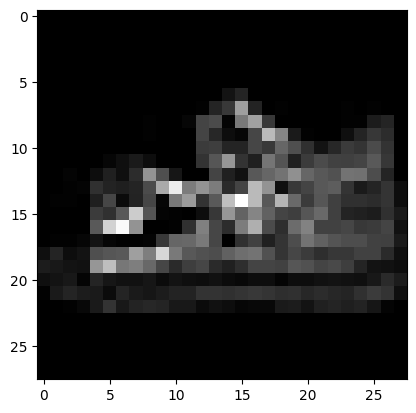

In [15]:
test_pred(285, w1, b1, w2, b2)

In [16]:
dev_preds = make_preds(x_dev, w1, b1, w2, b2)
get_acc(dev_preds, y_dev)

[3 3 3 6 1 3 0 9 9 6 4 2 4 4 5 2 7 0 2 1 0 4 6 4 9 0 5 9 4 3 1 2 6 1 4 0 3
 6 8 9 3 5 4 5 6 8 9 0 1 5 3 7 6 2 3 2 9 6 6 5 6 1 3 0 2 3 2 8 5 5 8 7 7 0
 6 9 8 8 1 4 2 3 2 0 4 8 8 5 0 9 2 5 7 2 9 5 0 0 6 2 3 4 7 2 1 0 0 9 8 2 1
 9 9 5 0 5 2 0 4 7 7 9 8 5 7 8 7 4 7 7 5 6 3 1 4 0 3 3 6 3 5 2 9 4 0 6 2 4
 8 3 2 1 5 2 5 4 3 6 7 1 3 1 5 9 5 2 8 9 5 3 5 7 1 5 4 8 4 9 4 9 3 1 8 2 8
 9 9 2 3 4 5 9 4 3 1 4 2 2 7 3 7 2 0 8 6 5 4 0 9 4 9 4 9 6 1 4 3 7 9 5 1 2
 7 4 6 9 7 4 0 5 8 4 2 3 3 2 9 3 9 3 8 2 5 1 9 9 7 9 2 1 0 4 0 7 5 6 0 0 0
 0 8 7 7 9 6 8 8 7 0 8 8 4 3 5 2 1 7 9 5 2 0 8 0 2 5 9 8 3 5 5 7 9 6 9 3 6
 3 2 8 1 5 1 6 1 8 3 1 9 2 2 0 0 9 9 3 2 6 1 0 7 7 9 5 7 3 5 7 0 4 4 6 8 0
 6 4 5 3 4 3 5 2 7 5 2 7 8 3 1 6 0 4 7 3 8 2 3 6 5 0 8 6 2 5 0 0 4 7 4 8 6
 7 8 9 3 8 7 4 1 4 4 0 1 1 0 4 8 2 8 0 4 7 4 6 2 8 4 2 0 5 3 1 1 0 8 9 9 5
 6 0 3 4 8 9 7 5 5 7 9 7 7 4 8 6 5 7 4 6 8 1 2 5 6 0 0 4 6 9 7 1 5 3 5 7 6
 5 4 2 9 7 9 6 7 2 5 1 8 3 8 6 1 5 3 4 0 2 4 2 3 1 8 9 9 3 8 7 1 3 7 5 9 1
 2 8 3 1 1 9 5 8 0 0 3 7 

0.848